In [1]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import wandb
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from torchviz import make_dot

# Initialize wandb
wandb.init(project="t15")



wandb: Currently logged in as: boredxmc (boredxmc-school). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [2]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
# Load data
file_path = r'D:\24phd7039\biomedical-research\datasets\csv_files\datasets_subject_01_to_10_scidata\GDN0009\GDN0009_1_Resting.csv'
df = pd.read_csv(file_path)
df = df.iloc[:len(df)//16]

# Preprocess data
seq_len = 2000
input_features = 2  # radar_i, radar_q
output_features = 1  # tfm_ecg2

data = df.values.astype(np.float32)
X = np.array([data[i:i+seq_len, :input_features] for i in range(len(data) - seq_len)])
y = data[seq_len:, input_features:input_features+output_features]

# Convert to PyTorch tensors
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
batch_size =  100
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

print(f"Loaded dataset: {len(dataset)} samples")


Loaded dataset: 79175 samples


In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Model parameters
hidden_size = 100
num_layers = 4
learning_rate = 0.0001
epochs = 10

# Initialize model, loss function, optimizer
model = LSTMModel(input_features, hidden_size, output_features, num_layers).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Watch the model with wandb
wandb.watch(model)


In [5]:
def train_model(model, train_loader, epochs):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero gradients, forward pass, backward pass, and optimize
            optimizer.zero_grad()
            predictions = model(inputs)
            loss = loss_fn(predictions, targets)
            loss.backward()
            optimizer.step()

            # Track batch loss
            epoch_loss += loss.item()

            # Log batch loss
            wandb.log({"Batch Loss": loss.item()})

            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # Log epoch loss
        avg_epoch_loss = epoch_loss / len(train_loader)
        wandb.log({"Epoch Loss": avg_epoch_loss})
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_epoch_loss:.4f}")

    return model

# Train the model
model = train_model(model, train_loader, epochs)


Epoch [1/10], Batch [1/792], Loss: 0.1709
Epoch [1/10], Batch [101/792], Loss: 0.0034
Epoch [1/10], Batch [201/792], Loss: 0.0663
Epoch [1/10], Batch [301/792], Loss: 0.0070
Epoch [1/10], Batch [401/792], Loss: 0.0083
Epoch [1/10], Batch [501/792], Loss: 0.0209
Epoch [1/10], Batch [601/792], Loss: 0.0091
Epoch [1/10], Batch [701/792], Loss: 0.0039
Epoch [1/10] Loss: 0.0714
Epoch [2/10], Batch [1/792], Loss: 0.1128
Epoch [2/10], Batch [101/792], Loss: 0.0011
Epoch [2/10], Batch [201/792], Loss: 0.0641
Epoch [2/10], Batch [301/792], Loss: 0.0092
Epoch [2/10], Batch [401/792], Loss: 0.0052
Epoch [2/10], Batch [501/792], Loss: 0.0243
Epoch [2/10], Batch [601/792], Loss: 0.0115
Epoch [2/10], Batch [701/792], Loss: 0.0028
Epoch [2/10] Loss: 0.0572
Epoch [3/10], Batch [1/792], Loss: 0.0155
Epoch [3/10], Batch [101/792], Loss: 0.0021
Epoch [3/10], Batch [201/792], Loss: 0.0347
Epoch [3/10], Batch [301/792], Loss: 0.0067
Epoch [3/10], Batch [401/792], Loss: 0.0037
Epoch [3/10], Batch [501/792],

In [6]:
# Save the model
torch.save(model.state_dict(), "lstm_model.pth")
print("Model saved.")

# Evaluate the model
def evaluate_model(model, data_loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            predictions = model(inputs)
            loss = loss_fn(predictions, targets)
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Evaluation Loss: {avg_loss:.4f}")
    wandb.log({"Evaluation Loss": avg_loss})
    return avg_loss

# Evaluate on training data
evaluate_model(model, train_loader)


Model saved.
Evaluation Loss: 0.0657


0.06571679511361796

In [7]:
def evaluate_and_save(model, data_loader, csv_path="predicted_vs_actual.csv"):
    model.eval()
    predictions_list = []
    actual_list = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            predictions = model(inputs)
            predictions_list.append(predictions.cpu().numpy())
            actual_list.append(targets.cpu().numpy())

    # Save predictions and actuals to CSV
    predictions_array = np.concatenate(predictions_list, axis=0)
    actual_array = np.concatenate(actual_list, axis=0)
    df = pd.DataFrame({
        "Predicted": predictions_array.flatten(),
        "Actual": actual_array.flatten()
    })
    df.to_csv(csv_path, index=False)
    print(f"Saved predictions vs. actuals to {csv_path}")
    return df

# Save predictions
predicted_vs_actual_df = evaluate_and_save(model, train_loader)


Saved predictions vs. actuals to predicted_vs_actual.csv


In [8]:
# Visualize the model architecture
sample_input = torch.randn(1, seq_len, input_features).to(device)
output = model(sample_input)

dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("lstm_model_architecture", format="png")
print("Model architecture plot saved as lstm_model_architecture.png")


Model architecture plot saved as lstm_model_architecture.png


In [9]:
def replace_and_save_predictions(model, original_csv_path, output_csv_path):
    model.eval()

    # Load the original data
    df = pd.read_csv(original_csv_path)
    data = df.values.astype(np.float32)
    
    # Prepare data for prediction
    seq_len = 100
    input_features = 2  # radar_i, radar_q
    output_features = 1  # tfm_ecg2

    X = np.array([data[i:i+seq_len, :input_features] for i in range(len(data) - seq_len)])
    X_tensor = torch.tensor(X).to(device)

    # Predict new tfm_ecg2 values
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            batch_input = X_tensor[i:i+batch_size]
            batch_predictions = model(batch_input)
            predictions.append(batch_predictions.cpu().numpy())

    # Flatten predictions and match to the original dataset
    predictions = np.concatenate(predictions, axis=0)
    new_tfm_ecg2 = np.full((len(data),), np.nan, dtype=np.float32)
    new_tfm_ecg2[seq_len:] = predictions.flatten()

    # Replace the tfm_ecg2 column in the DataFrame
    df.iloc[:, input_features] = new_tfm_ecg2

    # Save the modified DataFrame to a new CSV
    df.to_csv(output_csv_path, index=False)
    print(f"Updated CSV saved to {output_csv_path}")

# Replace the tfm_ecg2 values and save the new CSV
original_csv_path = r'D:\24phd7039\biomedical-research\datasets\csv_files\datasets_subject_01_to_10_scidata\GDN0003\GDN0003_1_Resting.csv'
output_csv_path = r'D:\24phd7039\biomedical-research\ml_files\utils\plot_folder\GDN0003\combined.csv'
replace_and_save_predictions(model, original_csv_path, output_csv_path)


Updated CSV saved to D:\24phd7039\biomedical-research\ml_files\utils\plot_folder\GDN0003\combined.csv


Mean Squared Error: 0.0657
Mean Absolute Error: 0.1938
Root Mean Squared Error: 0.2564
F1 Score: 0.1624
Accuracy: 0.9561


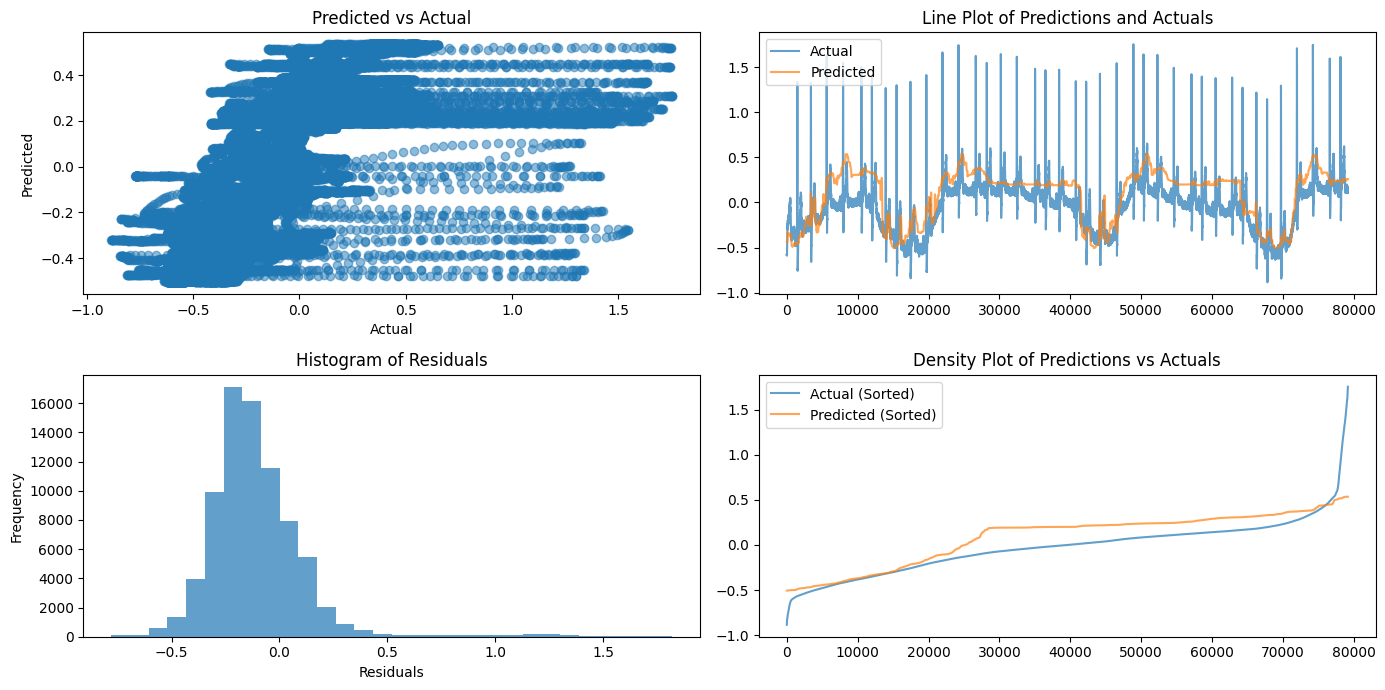

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, accuracy_score
import matplotlib.pyplot as plt

# Load the CSV
csv_path = r'D:\24phd7039\biomedical-research\ml_files\models\lstm\predicted_vs_actual.csv'
df = pd.read_csv(csv_path)

# Metrics calculation
predictions = df["Predicted"].values
actuals = df["Actual"].values

# Define a threshold for classification (optional for regression tasks)
threshold = 0.5
predicted_classes = (predictions > threshold).astype(int)
actual_classes = (actuals > threshold).astype(int)

# Regression Metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mse)

# Classification Metrics (if threshold is applied)
f1 = f1_score(actual_classes, predicted_classes)
accuracy = accuracy_score(actual_classes, predicted_classes)

# Print metrics
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Plot graphs
plt.figure(figsize=(14, 7))

# Scatter plot
plt.subplot(2, 2, 1)
plt.scatter(actuals, predictions, alpha=0.5)
plt.title("Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")

# Line plot
plt.subplot(2, 2, 2)
plt.plot(actuals, label="Actual", alpha=0.7)
plt.plot(predictions, label="Predicted", alpha=0.7)
plt.legend()
plt.title("Line Plot of Predictions and Actuals")

# Residuals Histogram
residuals = actuals - predictions
plt.subplot(2, 2, 3)
plt.hist(residuals, bins=30, alpha=0.7)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

# Density plot
plt.subplot(2, 2, 4)
plt.plot(sorted(actuals), label="Actual (Sorted)", alpha=0.7)
plt.plot(sorted(predictions), label="Predicted (Sorted)", alpha=0.7)
plt.legend()
plt.title("Density Plot of Predictions vs Actuals")

plt.tight_layout()
plt.show()


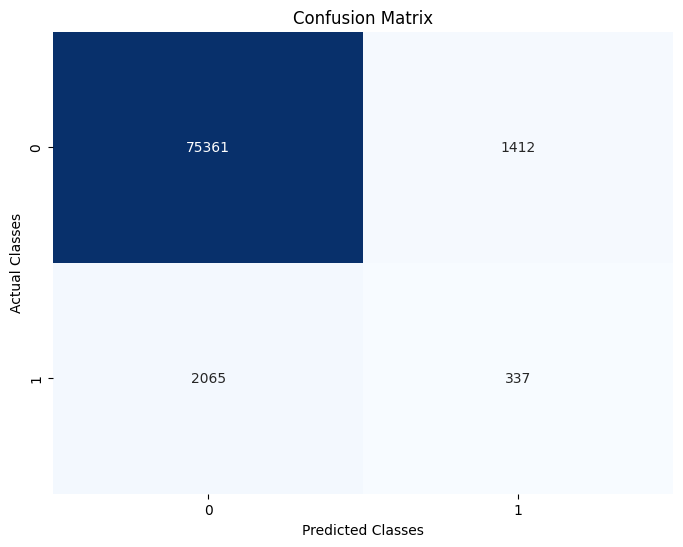

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(actual_classes, predicted_classes)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()
